# Detecting MCSs using a UNet and ERA5

- MCSs (labels) FLEXTRKR (PNNL, Zhe Feng) 
- ERA5
- 0.25-degree (similar high-resolution CESM)
- 2004-2019
- 1-hour temporal resolution
- North America domain (US)
- currently trained UNet 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from config import main_path_era
from id_selector import IDSelector
import dataset
import unet

### generate ID list

In [2]:
class_ids = IDSelector(main_path = main_path_era, 
                       start_year = 2004, 
                       end_year = 2005, 
                       month_only=[6], 
                       year_only=None, 
                       mcs_only=True, 
                       percent_train=0.8, 
                       percent_validate=0.1,)

# here we generate the list of IDs by loading from a presaved dictionary
IDlist = class_ids.generate_IDarray(dict_freq='1H')

# here we shuffle and split the IDs into a testing and training set
train_IDs, valid_IDs, test_IDs = class_ids.generate_traintest_split(IDlist, seed=0)

starting ID generation...
ID generation complete.


In [3]:
print(f"Training set contains ",len(train_IDs)," total training MCSs.")
print(f"Validation set contains ",len(valid_IDs)," total training MCSs.")
print(f"Testing set contains ",len(test_IDs)," total training MCSs.")

Training set contains  959  total training MCSs.
Validation set contains  137  total training MCSs.
Testing set contains  275  total training MCSs.


### initiate training, validation, and testing data

In [4]:
variables = ["cp","u850", "v850", "q850"]  #tmq ()

# cp is present in cesm (might be good to try to remove this; not being explicitly used for 
# detecting ARs/TCs)
# u and v at 850 in winds -- good to go for CESM
# (tmq -- total precipitable water)
# q not sure if it is output at different pressure levels for cesm
# The measurements of water vapour may be expressed in terms of precipitable water vapour (PWV), 
# which is the total atmospheric water vapour contained in a vertical air column of unit area from 
# the Earth’s surface to the top of the atmosphere (Alshawaf et al., 2017). 

In [5]:
# for training
training_generator = dataset.CustomDataset(list_IDs = train_IDs, 
                                              path_dataID = f"{main_path_era}/dl_files/1H/", 
                                              variable = variables, 
                                              batch_size = 32, dim = (121, 321), 
                                              n_channels = len(variables), 
                                              n_classes = 2, shuffle = True, 
                                              norm='zscore',
                                              )
train_load = DataLoader(training_generator, batch_size=1, shuffle=False, drop_last=False)

# for validation
validating_generator = dataset.CustomDataset(list_IDs = valid_IDs, 
                                              path_dataID = f"{main_path_era}/dl_files/1H/", 
                                              variable = variables, 
                                              batch_size = 16, dim = (121, 321), 
                                              n_channels = len(variables), 
                                              n_classes = 2, shuffle = False, 
                                              norm='zscore',
                                              )
valid_load = DataLoader(validating_generator, batch_size=1, shuffle=False, drop_last=False)

# for evaluation
testing_generator = dataset.CustomDataset(list_IDs = test_IDs, 
                                              path_dataID = f"{main_path_era}/dl_files/1H/", 
                                              variable = variables, 
                                              batch_size = 1, dim = (121, 321), 
                                              n_channels = len(variables), 
                                              n_classes = 2, shuffle = False, 
                                              norm='zscore',
                                              )
test_load = DataLoader(testing_generator, batch_size=1, shuffle=False, drop_last=False)

### training functions

In [7]:
def train(model, dataloader, weights=None):
    """
    Training function.
    
    Args:
        model (torch): pytorch neural network.
        dataloader (torch): pytorch dataloader.
        weights (boolean): weights for custom loss.
    
    """
    model.train()
    
    running_loss = 0.0
    corrcoef_loss = 0.0
    
    for data in dataloader:
        
        img_noisy = data['train'].squeeze(0)  #removal of added single batch from dataloader
        img_noisy = img_noisy.to(device)
        
        img_label = data['test'].squeeze(0)
        
        target = img_label.cpu()[:,1,:,:].squeeze() #crosssentropy
        target = target.to(device)

        img_label = img_label.to(device)  #IoU

        outputs = model(img_noisy.float())
        
        loss = criterion(outputs, target.long()) #crosssentropy
        closs = secondcrt(outputs, img_label.float())
        
        optimizer.zero_grad()   # back prop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        corrcoef_loss += closs.item()
    
    train_loss = running_loss / len(dataloader)
    coef_loss = corrcoef_loss / len(dataloader)
    
    return train_loss, coef_loss

In [8]:
def validate(model, dataloader, weights=None):
    """
    Validation function.
    
    Args:
        model: pytorch neural network.
        dataloader: pytorch dataloader.
        weights (boolean): weights for custom loss.
    
    """
    model.eval()
    
    running_loss = 0.0
    corrcoef_loss = 0.0
    
    with torch.no_grad():
        
        for i, data in enumerate(dataloader):

            img_noisy = data['train'].squeeze(0)
            img_noisy = img_noisy.to(device)

            img_label = data['test'].squeeze(0)
            
            target = img_label.cpu()[:,1,:,:].squeeze() #crosssentropy
            target = target.to(device)
            
            img_label = img_label.to(device)  #IoU

            outputs = model(img_noisy.float())
            
            loss = criterion(outputs, target.long()) #crosssentropy
            closs = secondcrt(outputs, img_label.float())
            
            running_loss += loss.item()
            corrcoef_loss += closs.item()
        
    val_loss = running_loss / len(dataloader)
    coef_loss = corrcoef_loss / len(dataloader)
    
    return val_loss, coef_loss

### initiate unet for training

In [9]:
net = unet.UNet(n_channels=4, n_classes=2)

In [10]:
LEARNING_RATE = 1e-4

# the optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, amsgrad=False)

# the loss function
criterion = nn.CrossEntropyLoss()   # adding weights to positive class
secondcrt = unet.IoULoss()

In [11]:
device = unet.get_device()
print(device)
net.to(device)

cuda:0


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [ ]:
NUM_EPOCHS = 10

train_loss = []
valid_loss = []

train_corr = []
valid_corr = []

for enum, epoch in enumerate(range(NUM_EPOCHS)):
    
    t_loss, t_corr = train(net, train_load, weights = None)
    v_loss, v_corr = validate(net, valid_load, weights = None)
    
    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    
    train_corr.append(t_corr)
    valid_corr.append(v_corr)
    
    print(f"Epoch {epoch + 1} of {NUM_EPOCHS}; Train Loss: {t_loss:.4f}, Train: {t_corr:.4f}; Val Loss: {v_loss:.4f}, Val: {v_corr:.4f}")

Epoch 1 of 10; Train Loss: 0.1254, Train: 0.3642; Val Loss: 0.0670, Val: 0.2475
Epoch 2 of 10; Train Loss: 0.0573, Train: 0.2028; Val Loss: 0.0532, Val: 0.1680
Epoch 3 of 10; Train Loss: 0.0471, Train: 0.1494; Val Loss: 0.0451, Val: 0.1283
Epoch 4 of 10; Train Loss: 0.0393, Train: 0.1169; Val Loss: 0.0395, Val: 0.1004
Epoch 5 of 10; Train Loss: 0.0336, Train: 0.0934; Val Loss: 0.0361, Val: 0.0855
Epoch 6 of 10; Train Loss: 0.0299, Train: 0.0778; Val Loss: 0.0335, Val: 0.0731


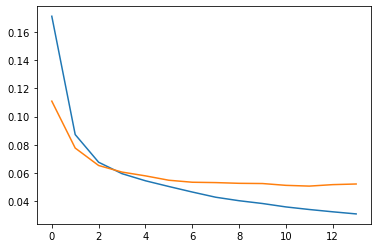

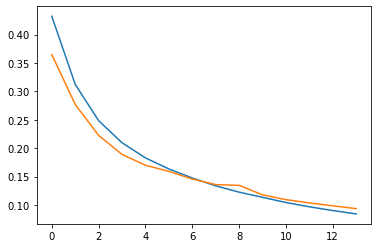

In [18]:
%matplotlib inline
plt.plot(train_loss[:]);
plt.plot(valid_loss[:]);
plt.show()

plt.plot(train_corr[:]);
plt.plot(valid_corr[:]);
plt.show()

In [19]:
#torch.save(net.state_dict(), 'model_mcs_unet5.pt')

### evaluation

In [20]:
def generate_predictions(model, IDs, torch_dataset, torch_dataloader, num_classes=2):
    
    shape_0 = IDs.shape[0]
    shape_1 = torch_dataset.__getitem__(0)['train'].squeeze().shape[1]
    shape_2 = torch_dataset.__getitem__(0)['train'].squeeze().shape[2]

    predictions_ = np.zeros((shape_0, num_classes, shape_1, shape_2))
    pred_labels_ = np.zeros((shape_0, num_classes, shape_1, shape_2))
    
    indx_ = []
    model.eval()
    count_ = 0
    
    m = nn.Softmax(dim=1)

    with torch.no_grad():
        
        for i, data in enumerate(torch_dataloader):
            
            img_noisy = data['train'].squeeze(0)
            img_noisy = img_noisy.to(device)
            
            img_label = data['test'].squeeze(0)
            img_label = img_label.to(device)
            
            indx_.append(data['minibatch_indx'])
            
            outputs = model(img_noisy.float())
            
            outputs = m(outputs)
            
            for out_ in range(outputs.shape[0]):
                
                predictions_[count_, ...] = outputs.cpu()[out_, ...]
                pred_labels_[count_, ...] = img_label.cpu()[out_, ...]
                
                count_ += 1
                
    indx_ = np.array([ind for i in indx_ for ind in i.numpy()])
    
    return predictions_.astype(np.float32), pred_labels_.astype(np.float32), indx_

In [21]:
predictions_, pred_labels_, indx_ = generate_predictions(net, test_IDs, testing_generator, test_load,)

0


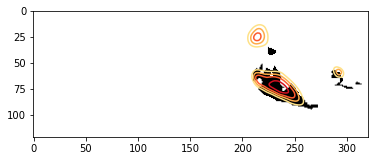

1


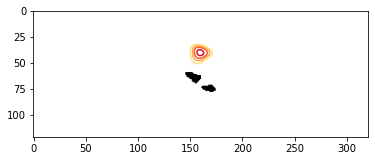

2


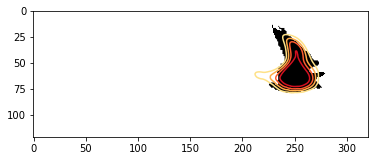

3


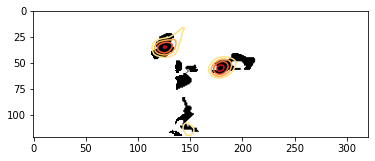

4


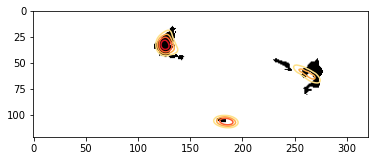

5


/glade/scratch/molina/ipykernel_153722/4184477082.py:4: UserWarning: No contour levels were found within the data range.
  plt.contour(predictions_[i,1,:,:], vmin=0, vmax=1, levels=[0.2,0.4,0.6,0.8,1.0], cmap='YlOrRd');


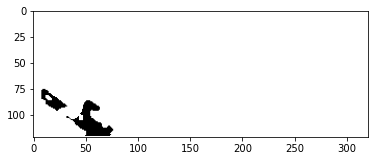

6


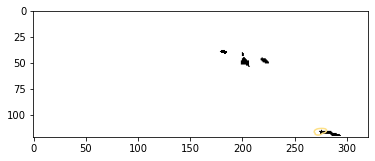

7


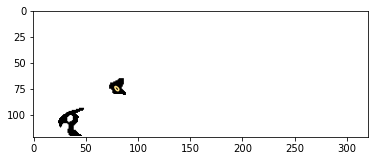

8


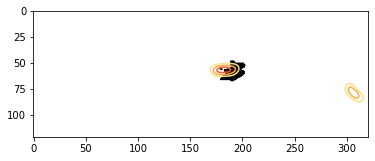

9


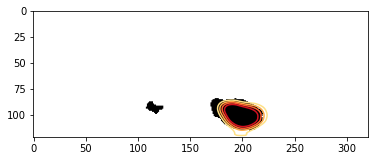

10


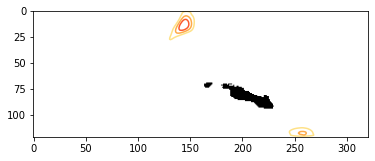

11


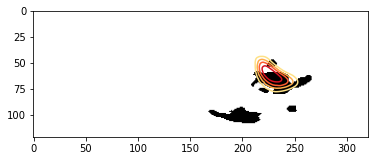

12


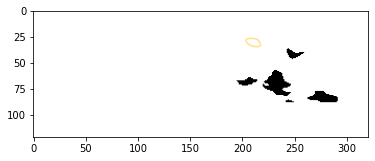

13


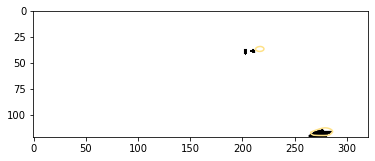

14


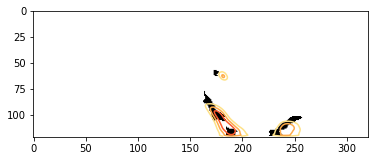

15


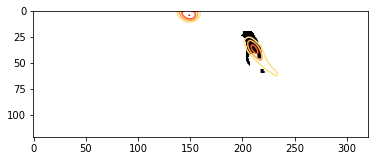

16


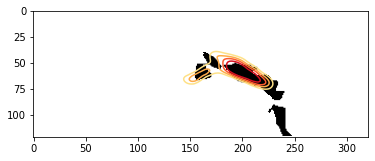

17


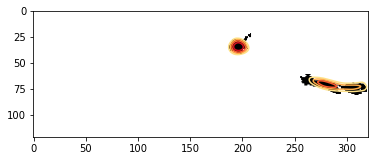

18


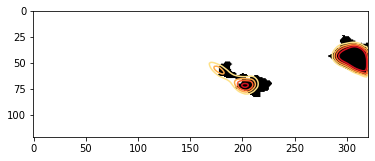

19


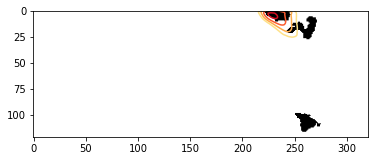

20


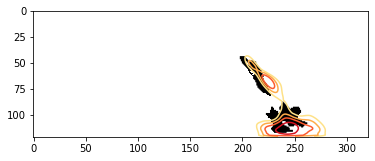

21


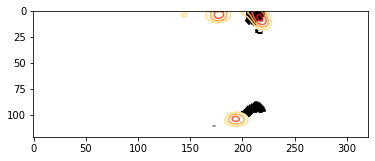

22


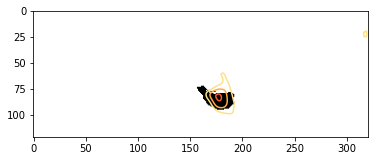

23


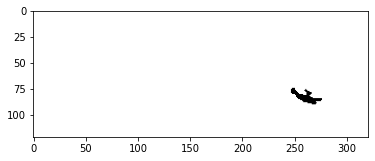

24


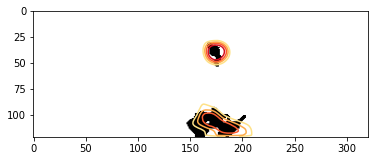

25


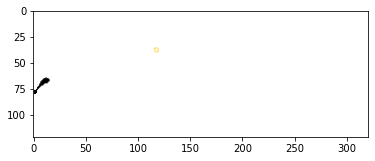

26


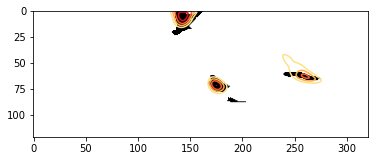

27


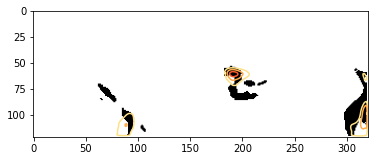

28


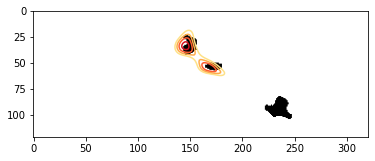

29


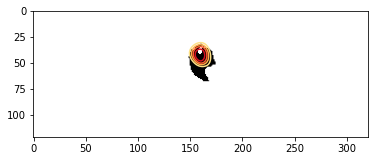

30


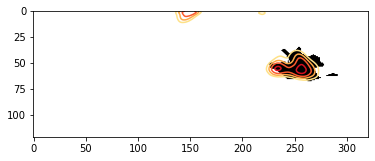

31


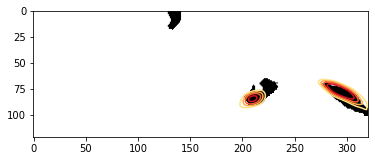

32


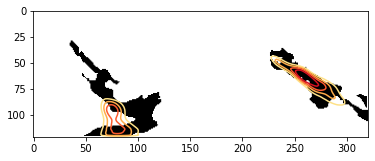

33


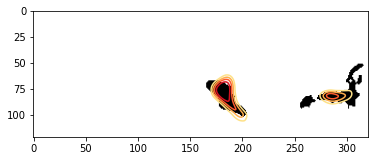

34


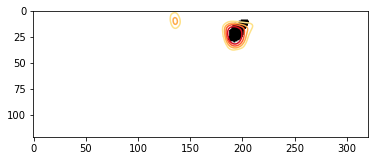

35


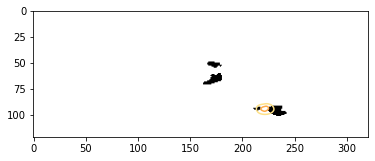

36


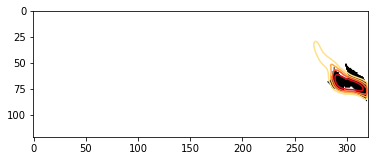

37


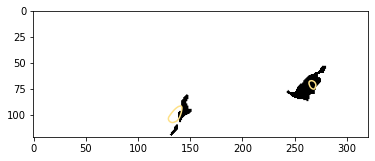

38


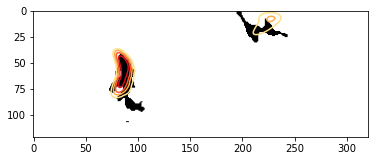

39


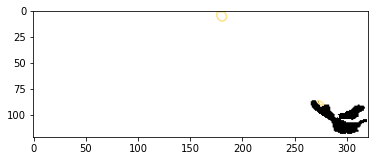

40


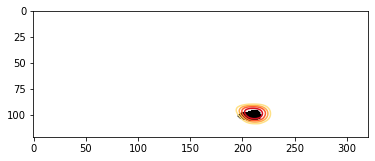

41


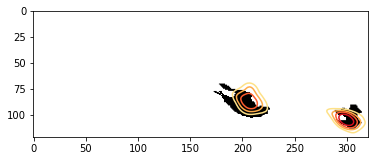

42


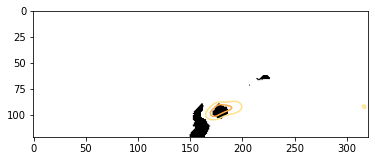

43


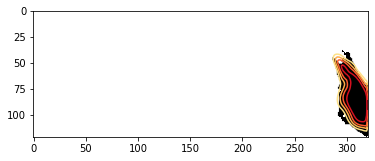

44


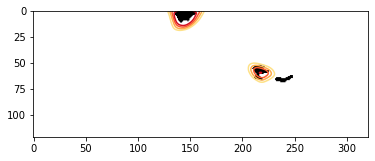

45


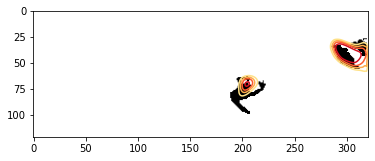

46


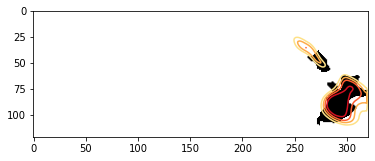

47


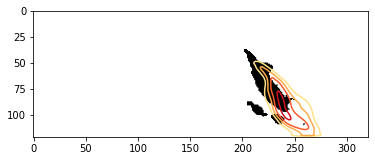

48


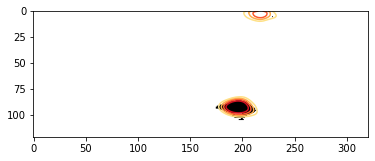

49


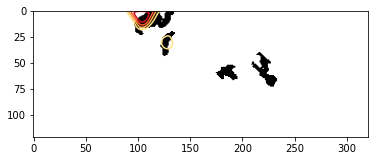

50


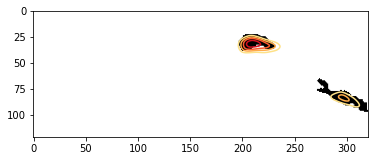

51


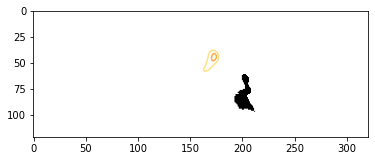

52


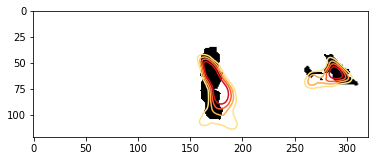

53


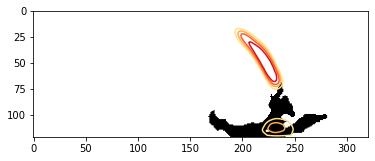

54


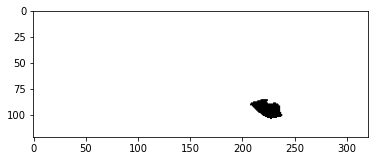

55


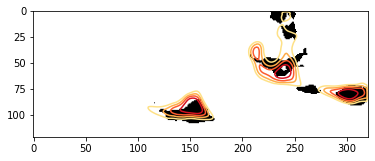

56


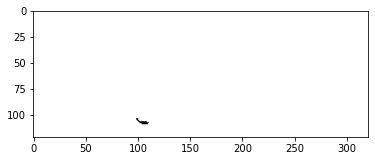

57


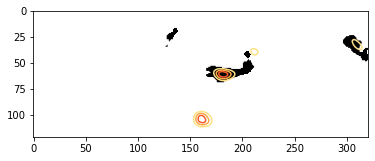

58


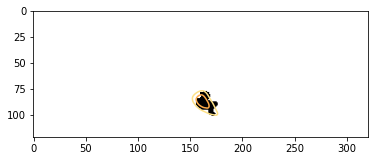

59


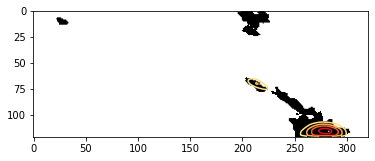

60


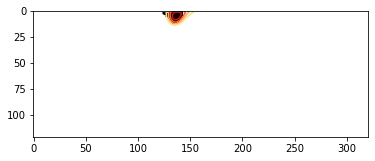

61


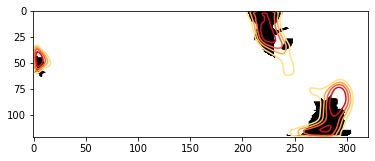

62


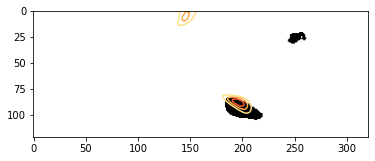

63


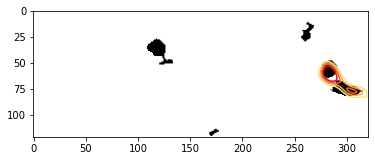

64


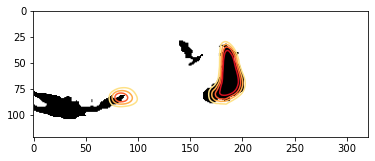

65


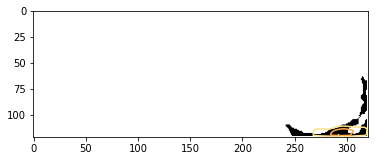

66


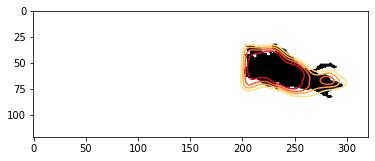

67


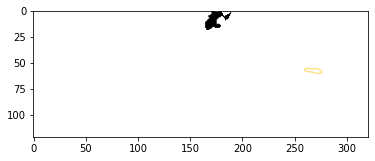

68


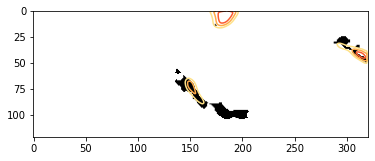

69


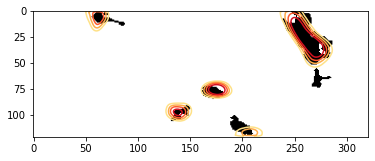

70


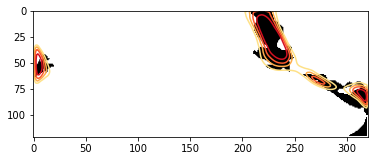

71


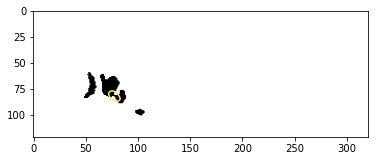

72


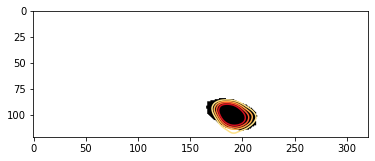

73


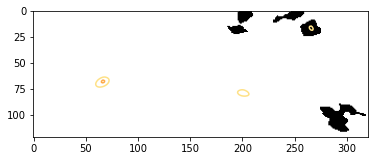

74


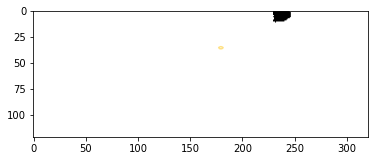

75


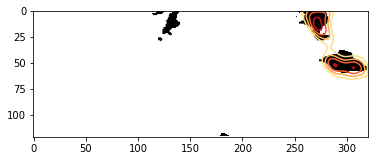

76


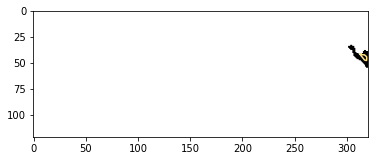

77


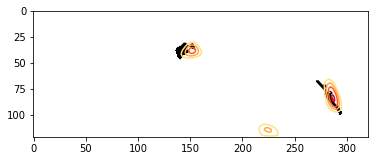

78


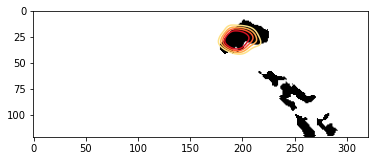

79


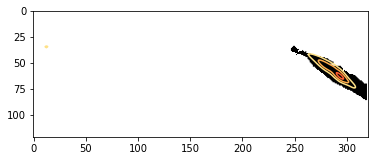

80


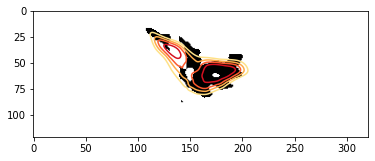

81


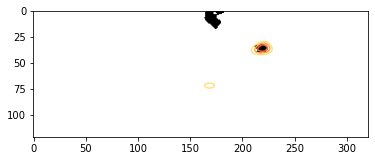

82


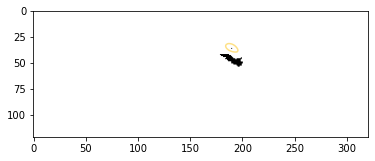

83


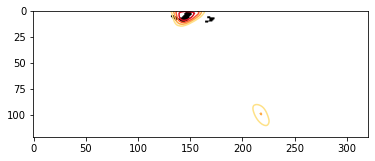

84


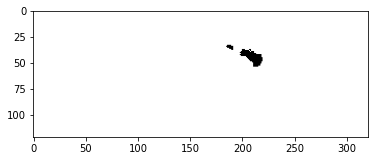

85


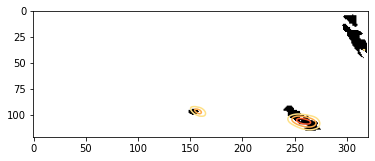

86


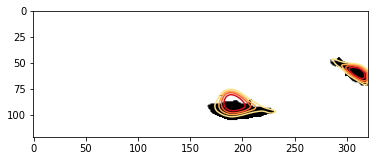

87


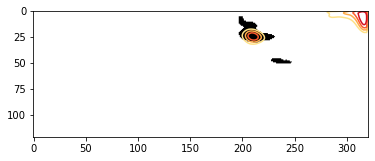

88


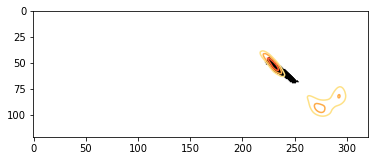

89


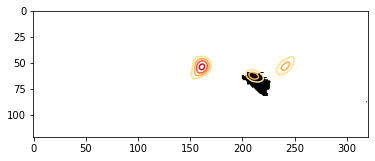

90


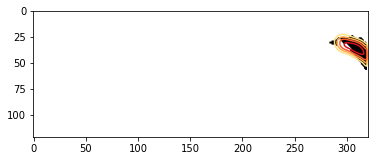

91


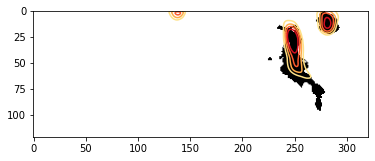

92


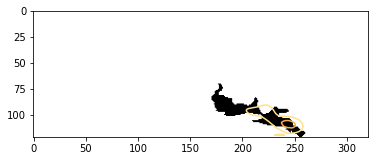

93


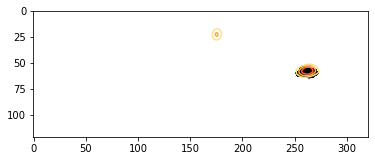

94


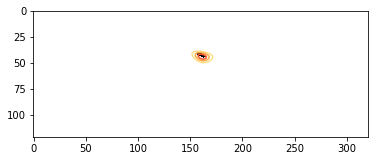

95


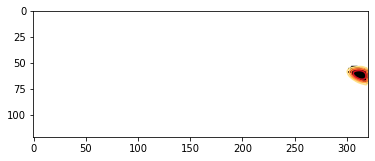

96


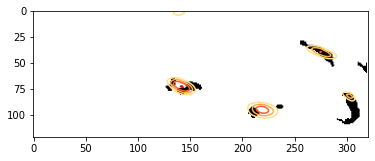

97


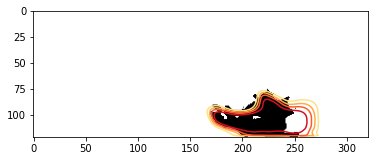

98


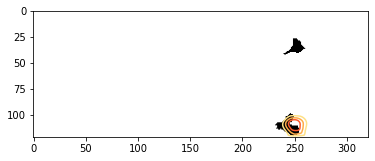

99


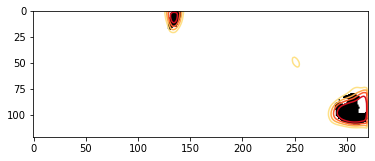

In [33]:
for i in range(100):
    print(i)
    plt.imshow(pred_labels_[i,1,:,:], vmin=0, vmax=1, cmap='Greys');
    plt.contour(predictions_[i,1,:,:], vmin=0, vmax=1, levels=[0.2,0.4,0.6,0.8,1.0], cmap='YlOrRd'); 
    plt.show()